In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.optim import Adam
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from peft import get_peft_model, LoraConfig

df = pd.read_csv('test_food_bev_alc.csv')
data_cleaned = df.drop(columns=['link', 'typeID'])
label_split = data_cleaned['label'].str.split('/', expand=True)
label_split.columns = [f'label_part_{i+1}' for i in range(label_split.shape[1])]
data_expanded = pd.concat([data_cleaned.drop(columns=['label']), label_split], axis=1)

df = data_expanded
df.groupby("label_part_2").size().plot.bar()

unique_labels = df['label_part_2'].unique()
label_to_number = {label: idx for idx, label in enumerate(unique_labels, start=0)}
df['label_part_2_number'] = df['label_part_2'].map(label_to_number)



In [6]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = label_to_number


60754 7594 7595


/Users/physics2/Desktop/Archive/playground/erdos/.erdos/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/physics2/Desktop/Archive/playground/erdos/.erdos/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['label_part_2']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['product']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

class BertSequenceClassifier(nn.Module):
    def __init__(self, num_classes: int):
        super(BertSequenceClassifier, self).__init__()
        self.bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
        
        peft_config = LoraConfig(
            task_type="SEQ_CLS",
            r=4,
            lora_alpha=32,
            lora_dropout=0.01,
            target_modules=['query', 'key', 'value'],
        )
        
        self.bert_model = get_peft_model(self.bert_model, peft_config)

    def forward(self, input_ids, attention_mask, labels=None):
        return self.bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


In [8]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].squeeze(1).to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            outputs = model(input_ids=input_id, attention_mask=mask, labels=train_label)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss_train += loss.item()
            
            acc = (logits.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].squeeze(1).to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                outputs = model(input_ids=input_id, attention_mask=mask, labels=val_label)
                loss = outputs.loss
                logits = outputs.logits
                
                total_loss_val += loss.item()
                
                acc = (logits.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 3  
LR = 1e-4  

model = BertSequenceClassifier(num_classes=len(unique_labels))

train(model, df_train, df_val, LR, EPOCHS)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [9]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if use_cuda:
        model = model.cuda()

    predictions_labels = []
    true_labels = []
    total_acc_test = 0
    
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].squeeze(1).to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            outputs = model(input_ids=input_id, attention_mask=mask, labels=test_label)
            logits = outputs.logits

            acc = (logits.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            true_labels += test_label.cpu().numpy().flatten().tolist()
            predictions_labels += logits.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels


true_labels, pred_labels = evaluate(model, df_test)

In [12]:
# torch.save(model.state_dict(), "lora_finetuned_bert_model.pt")
model_new = BertSequenceClassifier(num_classes=len(unique_labels))
model_new.load_state_dict(torch.load("/Users/physics2/Desktop/Archive/playground/erdos/sandbox/lora_finetuned_bert_model.pt"))
model_new.eval()

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BertSequenceClassifier(
  (bert_model): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): BertForSequenceClassification(
        (bert): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0-11): 12 x BertLayer(
                (attention): BertAttention(
                  (self): BertSdpaSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=768, out_features=768, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.01, inplace=False)
               

In [13]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if use_cuda:
        model = model.cuda()

    predictions_labels = []
    true_labels = []
    total_acc_test = 0
    
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].squeeze(1).to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            outputs = model(input_ids=input_id, attention_mask=mask, labels=test_label)
            logits = outputs.logits

            acc = (logits.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            true_labels += test_label.cpu().numpy().flatten().tolist()
            predictions_labels += logits.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels


true_labels, pred_labels = evaluate(model_new, df_test)

Test Accuracy:  0.887


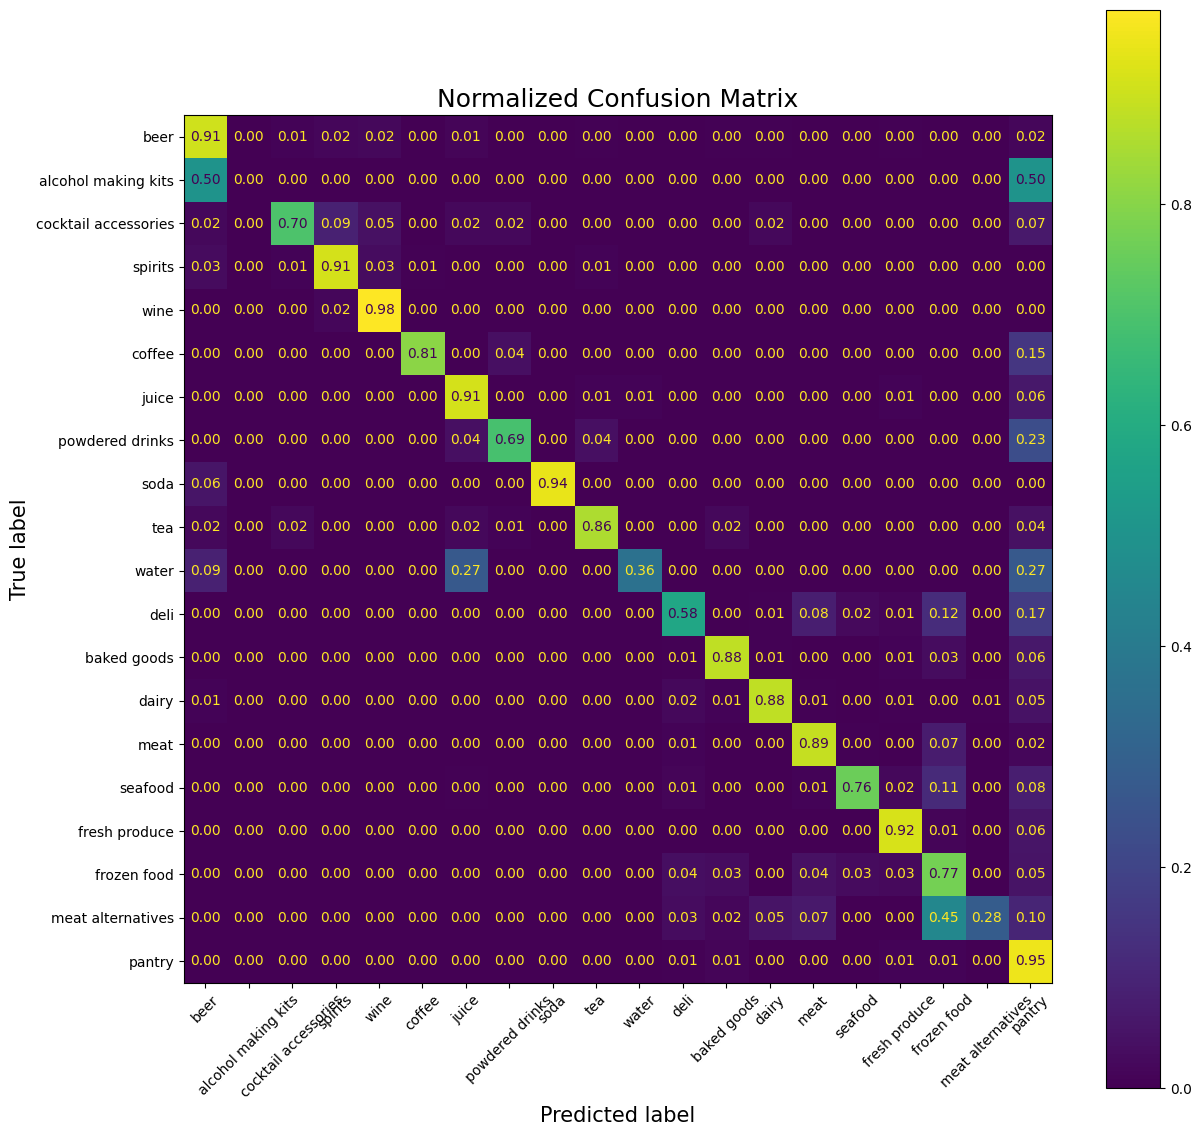

In [14]:
fig, ax = plt.subplots(figsize=(14, 14)) 

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))

disp.plot(ax=ax, cmap='viridis', xticks_rotation=45, values_format='.2f') 

ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
plt.title("Normalized Confusion Matrix", fontsize=18)
plt.xlabel("Predicted label", fontsize=15)
plt.ylabel("True label", fontsize=15)
plt.show()


In [21]:

example_input = "Anderson Valley Brewing Company Boont Amber12 fl oz"
fixed_text = " ".join(example_input.lower().split())

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

outputs = model_new(input_ids=input_id, attention_mask=mask)
logits = outputs.logits
prob = torch.nn.functional.softmax(logits, dim=1)[0]
number_to_label = {v: k for k, v in label_to_number.items()}


pred_label = number_to_label[logits.argmax(dim=1).item()]
print(f"Predicted label: {pred_label}")


Predicted label: beer


In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.optim import AdamW
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Load and preprocess data
df = pd.read_csv('../data_saved_models/test_food_bev_alc.csv')
data_cleaned = df.drop(columns=['link', 'typeID'])
label_split = data_cleaned['label'].str.split('/', expand=True)
label_split.columns = [f'label_part_{i+1}' for i in range(label_split.shape[1])]
data_expanded = pd.concat([data_cleaned.drop(columns=['label']), label_split], axis=1)

# Drop the 'alcohol making kits' class
df_filtered = data_expanded[data_expanded['label_part_2'] != 'alcohol making kits']
df_filtered = df_filtered[df_filtered['label_part_2'] != 'pantry']


# Update the label mapping and indices
unique_labels = df_filtered['label_part_2'].unique()
label_to_number_filtered = {label: idx for idx, label in enumerate(unique_labels)}

# Apply the new label mapping
df_filtered['label_part_2_number'] = df_filtered['label_part_2'].map(label_to_number_filtered)

# Split the dataset
np.random.seed(112)
df_train, df_val, df_test = np.split(df_filtered.sample(frac=1, random_state=35),
                                     [int(0.8*len(df_filtered)), int(0.9*len(df_filtered))])

print(len(df_train), len(df_val), len(df_test))

# Step 2: Define the custom Dataset class
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/Users/physics2/Desktop/Archive/playground/erdos/.erdos/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


41147 5143 5144


/Users/physics2/Desktop/Archive/playground/erdos/.erdos/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


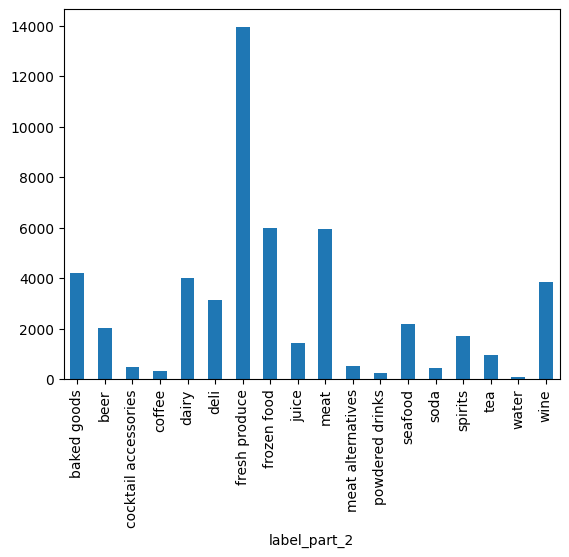

In [29]:
df =df_filtered
df.groupby("label_part_2").size().plot.bar()
unique_labels = df['label_part_2'].unique()
label_to_number = {label: idx for idx, label in enumerate(unique_labels, start=0)}
df['label_part_2_number'] = df['label_part_2'].map(label_to_number)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, label_to_number):
        self.labels = [label_to_number[label] for label in df['label_part_2']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['product']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

# Step 3: Ensure that you use MPS (Metal Performance Shaders) on M1
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

# Adjust the model configuration
config = BertConfig.from_pretrained('bert-base-uncased', num_hidden_layers=6, num_labels=len(label_to_number_filtered))

# Load the model with the updated configuration
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model = model.to(device)

# Step 4: Training function
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = CustomDataset(train_data, label_to_number_filtered), CustomDataset(val_data, label_to_number_filtered)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss().to(device)

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        model.train()
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].squeeze(1).to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            
            optimizer.zero_grad()

            outputs = model(input_ids=input_id, attention_mask=mask, labels=train_label)
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss_train += loss.item()
            
            acc = (logits.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        model.eval()
        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].squeeze(1).to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                outputs = model(input_ids=input_id, attention_mask=mask, labels=val_label)
                loss = outputs.loss
                logits = outputs.logits
                
                total_loss_val += loss.item()
                
                acc = (logits.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
# Train the model
EPOCHS = 3  # Adjust as needed
LR = 1e-4   # Adjust as needed

train(model, df_train, df_val, LR, EPOCHS)

# Step 5: Evaluation function
def evaluate(model, test_data):
    test = CustomDataset(test_data, label_to_number_filtered)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)
    
    model.eval()
    predictions_labels = []
    true_labels = []
    total_acc_test = 0
    
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].squeeze(1).to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            outputs = model(input_ids=input_id, attention_mask=mask, labels=test_label)
            logits = outputs.logits

            acc = (logits.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            true_labels += test_label.cpu().numpy().flatten().tolist()
            predictions_labels += logits.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

# Evaluate the model
true_labels, pred_labels = evaluate(model, df_test)

# Step 6: Generate Confusion Matrix
fig, ax = plt.subplots(figsize=(14, 14))

cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(label_to_number_filtered)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_to_number_filtered.keys()))

disp.plot(ax=ax, cmap='viridis', xticks_rotation=45, values_format='.2f')
plt.show()

# Save the model
torch.save(model.state_dict(), "reduced_layer_bert_model_filtered.pt")

# Load the model for inference
model_new = BertForSequenceClassification(config=config)
model_new.load_state_dict(torch.load("reduced_layer_bert_model_filtered.pt"))
model_new.eval()

# Inference example
example_input = "Lamb Shank Fresh"
fixed_text = " ".join(example_input.lower().split())

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

outputs = model_new(input_ids=input_id, attention_mask=mask)
logits = outputs.logits
prob = torch.nn.functional.softmax(logits, dim=1)[0]
number_to_label_filtered = {v: k for k, v in label_to_number_filtered.items()}

# Get predicted label name
pred_label = number_to_label_filtered[logits.argmax(dim=1).item()]
print(f"Predicted label: {pred_label}")
